# Malware Names

Dealing with malware names...

Starting by filtering only the selected vendors, then understanding the unique number of names per vendor.

In [1]:
from IPython.display import display
from leven import levenshtein
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

data_folder = 'data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'
vendors_selected_file = data_folder + 'vendors_selected.csv.gz'
selected_vendors = ["Rising", "NANO-Antivirus", "Microsoft", "VBA32",
                    "TrendMicro", "Comodo", "AhnLab-V3", "Panda",
                    "Malwarebytes", "K7GW", "K7AntiVirus", "Symantec",
                    "MicroWorld-eScan", "F-Secure", "Ikarus", "DrWeb",
                    "Emsisoft", "Fortinet", "TrendMicro-HouseCall", "Avast",
                    "BitDefender", "AVG", "Kaspersky", "GData", "VIPRE",
                    "Sophos", "McAfee", "McAfee-GW-Edition", "ESET-NOD32"]

In [2]:
# Filter down vendors
# vendors = pd.read_csv(vendors_file, dtype=str)
# vendors = vendors.set_index('link')
# vendors = vendors[selected_vendors]
# vendors.to_csv(vendors_selected_file, compression='gzip')
vendors = pd.read_csv(vendors_selected_file, dtype=str)
vendors = vendors.set_index('link')
vendors.replace('Clean', np.nan, inplace=True)

In [62]:
unique_names = dict()
names_count = dict()
for vendor in vendors:
    unique_names[vendor] = vendors[vendor].dropna().unique()
    names_count[vendor] = len(vendors[vendor].dropna().unique())
    
names_count = pd.Series(names_count)

Graph showing the unique number of names per vendor:

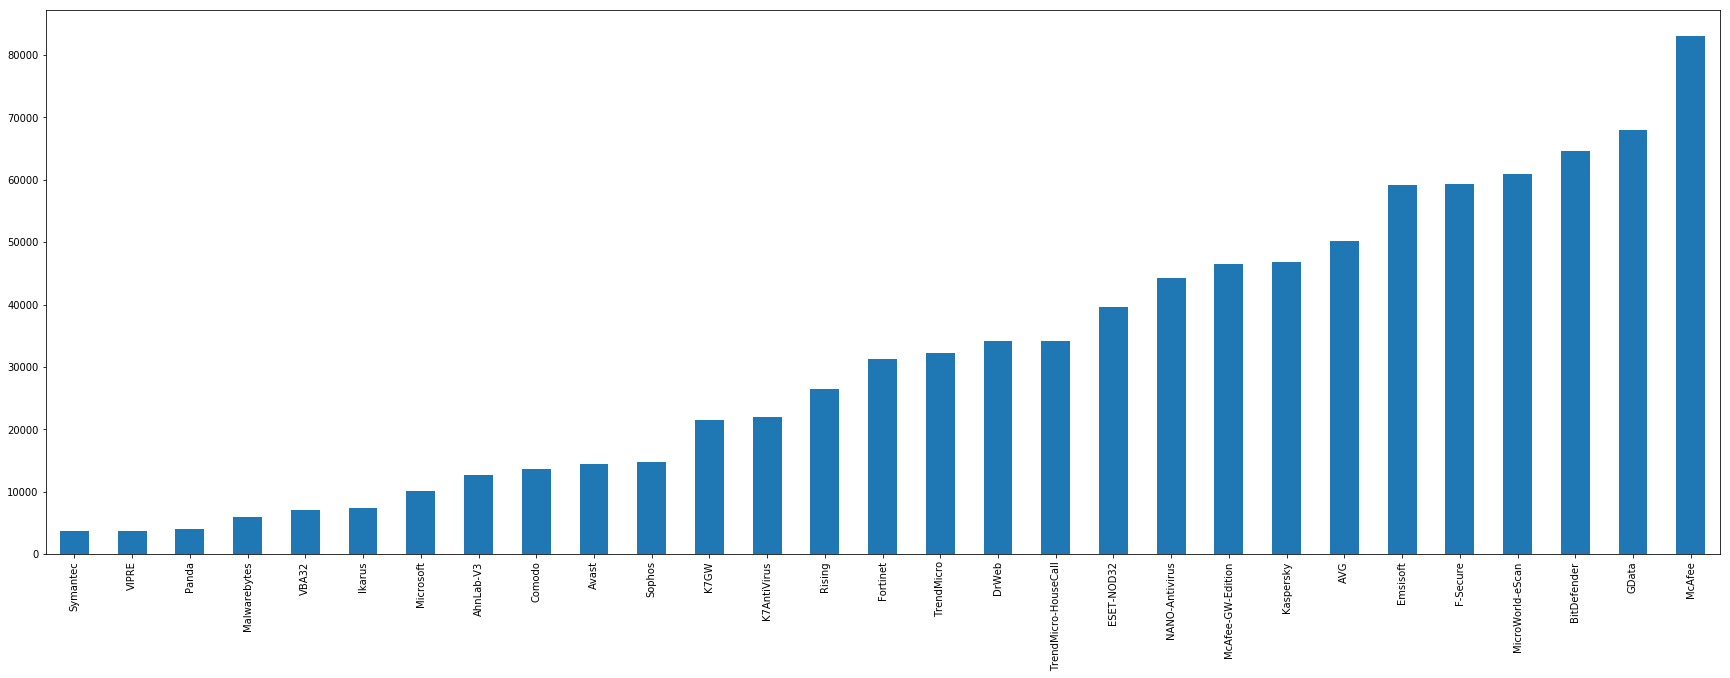

In [4]:
names_count.sort_values().plot.bar(figsize=((30, 10)))
plt.show()

## Understanding names

We want to split the malware into various levels and classes.

The highest level should be the propagation type: Virus, Worm, Trojan.

Bellow propagation type comes malware purpose and/or family.

### First Filterting

An inicial idea is to remove keywords below a given threshold, < 2 chars long. Keywords with 2 chars may still be relevant, like 'PE', 'BD', etc.

In [127]:
regex = re.compile(r'\W')

unique_keywords = dict()
filtered_names = dict()

for vendor in unique_names.keys():
    unique_keywords[vendor] = list()
    filtered_names[vendor] = set()
    for name in unique_names[vendor]:
        name = regex.split(name)
        unique_keywords[vendor] += name
        name = list(filter(lambda x: len(x) > 1, name))
        filtered_names[vendor].update(['.'.join(name)])

In [137]:
display('Filtered out of total unique names:')
for vendor in filtered_names.keys():
    display('{} {}/{}'.format(vendor, len(filtered_names[vendor]), len(unique_names[vendor])))

'Filtered out of total unique names:'

'Rising 26077/26424'

'NANO-Antivirus 44210/44210'

'Microsoft 7892/10051'

'VBA32 6838/7078'

'TrendMicro 31722/32285'

'Comodo 12832/13656'

'AhnLab-V3 12325/12705'

'Panda 3637/4002'

'Malwarebytes 5707/5927'

'K7GW 21549/21549'

'K7AntiVirus 21956/21967'

'Symantec 3411/3731'

'MicroWorld-eScan 60023/60899'

'F-Secure 58432/59344'

'Ikarus 7022/7322'

'DrWeb 33723/34097'

'Emsisoft 58324/59089'

'Fortinet 30197/31340'

'TrendMicro-HouseCall 33626/34156'

'Avast 13380/14407'

'BitDefender 63750/64682'

'AVG 49302/50201'

'Kaspersky 45702/46879'

'GData 66903/68002'

'VIPRE 3420/3752'

'Sophos 13347/14704'

'McAfee 82023/82982'

'McAfee-GW-Edition 45593/46547'

'ESET-NOD32 36772/39615'

Using levenshtein distance to reduce manual work

In [ ]:
test = unique_names['Symantec']

display(test[10])
for i in test:
    if levenshtein(test[10], i) < len(test[10]) - 1:
        display(i)